# Imports

In [1]:
import os
import h5py
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from sklearn import metrics, manifold, decomposition

# Images

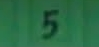

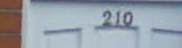

In [2]:
train_dir = 'svhn_large_data/train'
test_dir = 'svhn_large_data/test'
extra_dir = 'svhn_large_data/extra'

display.display(display.Image(test_dir + '/' + str(1) + '.png'), 
                display.Image(test_dir + '/' + str(2) + '.png'))

# Data Preprocessing

In [3]:
# Extract metadata
def extract_metadata(dr):
    metadata = {}
    fl = h5py.File(dr + '/digitStruct.mat')
    
    for i in xrange(len([x for x in os.listdir(dr) if x.split('.')[1] == 'png'])):        
        name = fl['digitStruct']['name'][i][0]
        bbox = fl['digitStruct']['bbox'][i][0]
        image_metadata = []
    
        if len(fl[bbox]['label']) == 1:    
            digit_metadata = {}
            digit_metadata['height'] = fl[bbox]['height'][0][0]
            digit_metadata['width'] = fl[bbox]['width'][0][0]
            digit_metadata['top'] = fl[bbox]['top'][0][0]
            digit_metadata['left'] = fl[bbox]['left'][0][0]
            digit_metadata['label'] = fl[bbox]['label'][0][0]
            image_metadata.append(digit_metadata)                    
        else:
            for j in xrange(len(fl[bbox]['label'])):
                digit_metadata = {}
                digit_metadata['height'] = [x for x in fl[fl[bbox]['height'][j][0]]][0][0]
                digit_metadata['width'] = [x for x in fl[fl[bbox]['width'][j][0]]][0][0]
                digit_metadata['top'] = [x for x in fl[fl[bbox]['top'][j][0]]][0][0]
                digit_metadata['left'] = [x for x in fl[fl[bbox]['left'][j][0]]][0][0]
                digit_metadata['label'] = [x for x in fl[fl[bbox]['label'][j][0]]][0][0]
                image_metadata.append(digit_metadata)                    
        
        metadata[''.join(chr(c) for c in fl[name][:])] = image_metadata
    
    return metadata

train_metadata = extract_metadata(train_dir)
test_metadata = extract_metadata(test_dir)
extra_metadata = extract_metadata(extra_dir)

In [4]:
# Extract images
img_size = 64
channels_num = 1

def extract_images(dr, md):
    data = np.ndarray((len([x for x in os.listdir(dr) if x.split('.')[1] == 'png']), 
                       img_size, img_size, channels_num)).astype(np.float32) 
    
    for i in xrange(1, len([x for x in os.listdir(dr) if x.split('.')[1] == 'png']) + 1):
        img = Image.open(dr + '/' + str(i) + '.png')
        img_height =  int(sum([x['height'] for x in md[str(i) + '.png']]))
        img_width = int(sum([x['width'] for x in md[str(i) + '.png']]))
        img_top = int(min([x['top'] for x in md[str(i) + '.png']]))
        img_left = int(min([x['left'] for x in md[str(i) + '.png']]))
        img_cropped = img.crop((img_left, img_top, img_left + img_width, img_top + img_height))
        img_gray = img_cropped.convert('L')
        img_resized = img_gray.resize((img_size, img_size), Image.ANTIALIAS)
        img_np = np.array(img_resized)
        img_normal = (img_np - (255.0 / 2.0)) / 255.0
        data[i - 1,:,:,:] = img_normal.reshape((img_size, img_size, channels_num))
        
    return data
    
train_images = extract_images(train_dir, train_metadata)
test_images = extract_images(test_dir, test_metadata)
extra_images = extract_images(extra_dir, extra_metadata)

# Data Balancing

In [5]:
# Training
train_total_digits = sum([len(train_metadata[str(i) + '.png']) 
                          for i in xrange(1, len(train_metadata) + 1)])
print('TRAINING:')
print('Number of images: %s' % str(train_images.shape[0]))
print('Number of digits: %d' % train_total_digits)

print('\nDigit percentages:')
s = ''
for n in xrange(10):
    value = len([train_metadata[str(i) + '.png'][j]['label'] 
                 for i in xrange(1, len(train_metadata) + 1) 
                 for j in xrange(len(train_metadata[str(i) + '.png'])) 
                 if train_metadata[str(i) + '.png'][j]['label'] == (10 if n == 0 else n)]) 
    s += '%d: %.2f%%, ' % (n, value / train_total_digits * 100)
print(s)
    
print('\nDigit per image percentages:')
s = ''
for n in xrange(1, 6):
    value = len([len(train_metadata[str(i) + '.png']) 
                 for i in xrange(1, len(train_metadata) + 1) 
                 if len(train_metadata[str(i) + '.png']) == n]) 
    s += '%d: %.2f%%, ' % (n, value / len(train_metadata) * 100)
print(s)
    
# Testing
test_total_digits = sum([len(test_metadata[str(i) + '.png']) 
                         for i in xrange(1, len(test_metadata) + 1)])
print('\n\nTESTING:')
print('Number of images: %s' % str(test_images.shape[0]))
print('Number of digits: %d' % test_total_digits)

print('\nDigit percentages:')
s = ''
for n in xrange(10):
    value = len([test_metadata[str(i) + '.png'][j]['label'] 
                 for i in xrange(1, len(test_metadata) + 1) 
                 for j in xrange(len(test_metadata[str(i) + '.png'])) 
                 if test_metadata[str(i) + '.png'][j]['label'] == (10 if n == 0 else n)]) 
    s += '%d: %.2f%%, ' % (n, value / test_total_digits * 100)
print(s)
    
print('\nDigit per image percentages:')
s = ''
for n in xrange(1, 6):
    value = len([len(test_metadata[str(i) + '.png']) 
                 for i in xrange(1, len(test_metadata) + 1) 
                 if len(test_metadata[str(i) + '.png']) == n])
    s += '%d: %.2f%%, ' % (n, value / len(test_metadata) * 100)
print(s)
    
# Extra
extra_total_digits = sum([len(extra_metadata[str(i) + '.png']) 
                          for i in xrange(1, len(extra_metadata) + 1)])
print('\n\nEXTRA:')
print('Number of images: %s' % str(extra_images.shape[0]))
print('Number of digits: %d' % extra_total_digits)

print('\nDigit percentages:')
s = ''
for n in xrange(10):
    value = len([extra_metadata[str(i) + '.png'][j]['label'] 
                 for i in xrange(1, len(extra_metadata) + 1) 
                 for j in xrange(len(extra_metadata[str(i) + '.png'])) 
                 if extra_metadata[str(i) + '.png'][j]['label'] == (10 if n == 0 else n)]) 
    s += '%d: %.2f%%, ' % (n, value / extra_total_digits * 100)
print(s)
    
print('\nDigit per image percentages:')
s = ''
for n in xrange(1, 6):
    value = len([len(extra_metadata[str(i) + '.png']) 
                 for i in xrange(1, len(extra_metadata) + 1) 
                 if len(extra_metadata[str(i) + '.png']) == n]) 
    s += '%d: %.2f%%, ' % (n, value / len(extra_metadata) * 100)
print(s)

TRAINING:
Number of images: 33402
Number of digits: 73257

Digit percentages:
0: 6.75%, 1: 18.92%, 2: 14.45%, 3: 11.60%, 4: 10.18%, 5: 9.39%, 6: 7.82%, 7: 7.64%, 8: 6.89%, 9: 6.36%, 

Digit per image percentages:
1: 15.38%, 2: 54.28%, 3: 26.02%, 4: 4.29%, 5: 0.03%, 


TESTING:
Number of images: 13068
Number of digits: 26032

Digit percentages:
0: 6.70%, 1: 19.59%, 2: 15.94%, 3: 11.07%, 4: 9.69%, 5: 9.16%, 6: 7.59%, 7: 7.76%, 8: 6.38%, 9: 6.13%, 

Digit per image percentages:
1: 19.00%, 2: 63.94%, 3: 15.92%, 4: 1.12%, 5: 0.02%, 


EXTRA:
Number of images: 202353
Number of digits: 531131

Digit percentages:
0: 8.58%, 1: 17.05%, 2: 14.07%, 3: 11.44%, 4: 9.53%, 5: 10.07%, 6: 7.83%, 7: 8.28%, 8: 6.66%, 9: 6.49%, 

Digit per image percentages:
1: 4.64%, 2: 35.45%, 3: 52.77%, 4: 7.09%, 5: 0.06%, 


In [6]:
# Create Training, Validation, and Testing sets
valid_num = 14000
train_num = len(train_metadata) + len(extra_metadata) - valid_num
test_num = len(test_metadata)
labels_num = 11
digits_num = 5

train_X = np.ndarray((train_num, img_size, img_size, channels_num)).astype(np.float32)
train_y = np.ndarray((train_num, digits_num, labels_num))
valid_X = np.ndarray((valid_num, img_size, img_size, channels_num)).astype(np.float32)
valid_y = np.ndarray((valid_num, digits_num, labels_num))
test_X = np.ndarray((test_num, img_size, img_size, channels_num)).astype(np.float32)
test_y = np.ndarray((test_num, digits_num, labels_num))

# Validation
valid_X[:valid_num // 7,:,:,:] = train_images[:valid_num // 7,:,:,:]
valid_X[valid_num // 7: valid_num,:,:,:] = extra_images[:valid_num - (valid_num // 7),:,:,:]

for i in xrange(1, valid_num // 7 + 1):
    for j in xrange(digits_num):
        if j < len(train_metadata[str(i) + '.png']):
            label = train_metadata[str(i) + '.png'][j]['label']
            valid_y[i - 1,j,:] = np.arange(labels_num) == (label if label != 10 else 0)
        else:
            valid_y[i - 1,j,:] = np.arange(labels_num) == 10

for i in xrange(1, valid_num - (valid_num // 7) + 1):
    for j in xrange(digits_num):
        if j < len(extra_metadata[str(i) + '.png']):
            label = extra_metadata[str(i) + '.png'][j]['label']
            valid_y[i + valid_num // 7 - 1,j,:] = np.arange(labels_num) == (label if label != 10 else 0)
        else:
            valid_y[i + valid_num // 7 - 1,j,:] = np.arange(labels_num) == 10

# Training    
train_X[:len(train_images) - (valid_num // 7)] = train_images[valid_num // 7:,:,:,:]
train_X[len(train_images) - (valid_num // 7):] = extra_images[valid_num - (valid_num // 7):,:,:,:]

for i in xrange(valid_num // 7 + 1, len(train_metadata) + 1):
    for j in xrange(digits_num):
        if j < len(train_metadata[str(i) + '.png']):
            label = train_metadata[str(i) + '.png'][j]['label']
            train_y[i - valid_num // 7 - 1,j,:] = np.arange(labels_num) == (label if label != 10 else 0)
        else:
            train_y[i - valid_num // 7 - 1,j,:] = np.arange(labels_num) == 10

for i in xrange(valid_num - (valid_num // 7) + 1, len(extra_metadata) + 1):
    for j in xrange(digits_num):
        if j < len(extra_metadata[str(i) + '.png']):
            label = extra_metadata[str(i) + '.png'][j]['label']
            index = i + len(train_images) - valid_num - 1
            train_y[index,j,:] = np.arange(labels_num) == (label if label != 10 else 0)
        else:
            train_y[index,j,:] = np.arange(labels_num) == 10
    
# Testing
test_X = test_images
for i in xrange(1, len(test_metadata) + 1):
    for j in xrange(digits_num):
        if j < len(test_metadata[str(i) + '.png']):
            label = test_metadata[str(i) + '.png'][j]['label']
            test_y[i - 1,j,:] = np.arange(labels_num) == (label if label != 10 else 0)
        else:
            test_y[i - 1,j,:] = np.arange(labels_num) == 10

In [7]:
# Training
train_total_digits = len([train_y[i][j] 
                          for i in xrange(len(train_y)) 
                          for j in xrange(5) 
                          if np.argmax(train_y[i][j]) != 10])
print('TRAINING:')
print('Number of images: %s' % str(train_X.shape[0]))
print('Number of digits: %d' % train_total_digits)

print('\nDigit percentages:')
s = ''
for n in xrange(10):
    value = len([x for x in [np.argmax(train_y[i][j]) 
                             for i in xrange(len(train_y)) 
                             for j in xrange(5) 
                             if np.argmax(train_y[i][j]) != 10] if x == n]) 
    s += '%d: %.2f%%, ' % (n, value / train_total_digits * 100)
print(s)
    
print('\nDigit per image percentages:')
s = ''
for n in xrange(1, 6):
    value = len([5 - len([x for x in train_y[i,:,10] if x == 1]) 
                 for i in xrange(len(train_y)) 
                 if 5 - len([x for x in train_y[i,:,10] if x == 1]) == n]) 
    s += '%d: %.2f%%, ' % (n, value / len(train_y) * 100)
print(s)
    
# Validation
valid_total_digits = len([valid_y[i][j] 
                          for i in xrange(len(valid_y)) 
                          for j in xrange(5) 
                          if np.argmax(valid_y[i][j]) != 10])
print('\n\nVALIDATION:')
print('Number of images: %s' % str(valid_X.shape[0]))
print('Number of digits: %d' % valid_total_digits)

print('\nDigit percentages:')
s = ''
for n in xrange(10):
    value = len([x for x in [np.argmax(valid_y[i][j]) 
                             for i in xrange(len(valid_y)) 
                             for j in xrange(5) 
                             if np.argmax(valid_y[i][j]) != 10] if x == n]) 
    s += '%d: %.2f%%, ' % (n, value / valid_total_digits * 100)
print(s)

print('\nDigit per image percentages:')
s = ''
for n in xrange(1, 6):
    value = len([5 - len([x for x in valid_y[i,:,10] if x == 1]) 
                 for i in xrange(len(valid_y)) 
                 if 5 - len([x for x in valid_y[i,:,10] if x == 1]) == n]) 
    s += '%d: %.2f%%, ' % (n, value / len(valid_y) * 100,)
print(s)
    
# Testing
test_total_digits = len([test_y[i][j] 
                         for i in xrange(len(test_y)) 
                         for j in xrange(5) 
                         if np.argmax(test_y[i][j]) != 10])
print('\n\nTESTING:')
print('Number of images: %s' % str(test_X.shape[0]))
print('Number of digits: %d' % test_total_digits)

print('\nDigit percentages:')
s = ''
for n in xrange(10):
    value = len([x for x in [np.argmax(test_y[i][j]) 
                             for i in xrange(len(test_y)) 
                             for j in xrange(5) 
                             if np.argmax(test_y[i][j]) != 10] if x == n]) 
    s += '%d: %.2f%%, ' % (n, value / test_total_digits * 100)
print(s)

print('\nDigit per image percentages:')
s = ''
for n in xrange(1, 6):
    value = len([5 - len([x for x in test_y[i,:,10] if x == 1]) 
             for i in xrange(len(test_y)) 
             if 5 - len([x for x in test_y[i,:,10] if x == 1]) == n]) 
    s += '%d: %.2f%%, ' % (n, value / len(test_y) * 100)
print(s)

TRAINING:
Number of images: 221755
Number of digits: 568371

Digit percentages:
0: 8.34%, 1: 17.26%, 2: 14.13%, 3: 11.46%, 4: 9.61%, 5: 9.99%, 6: 7.83%, 7: 8.21%, 8: 6.69%, 9: 6.48%, 

Digit per image percentages:
1: 6.17%, 2: 38.12%, 3: 48.98%, 4: 6.67%, 5: 0.05%, 


VALIDATION:
Number of images: 14000
Number of digits: 36016

Digit percentages:
0: 8.53%, 1: 17.54%, 2: 13.89%, 3: 11.44%, 4: 9.61%, 5: 10.01%, 6: 7.82%, 7: 8.13%, 8: 6.68%, 9: 6.34%, 

Digit per image percentages:
1: 5.95%, 2: 37.99%, 3: 48.96%, 4: 7.05%, 5: 0.05%, 


TESTING:
Number of images: 13068
Number of digits: 26032

Digit percentages:
0: 6.70%, 1: 19.59%, 2: 15.94%, 3: 11.07%, 4: 9.69%, 5: 9.16%, 6: 7.59%, 7: 7.76%, 8: 6.38%, 9: 6.13%, 

Digit per image percentages:
1: 19.00%, 2: 63.94%, 3: 15.92%, 4: 1.12%, 5: 0.02%, 


# Images

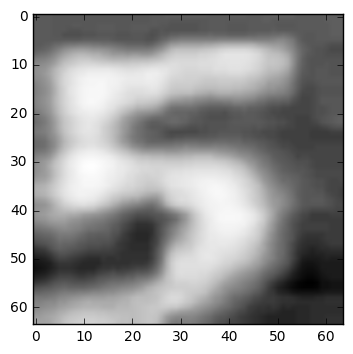

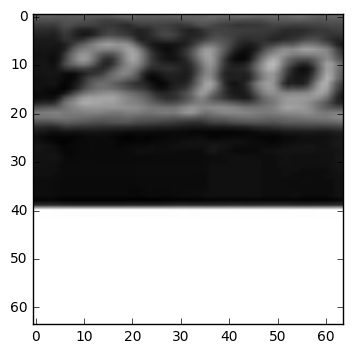

In [8]:
%matplotlib inline
plt.show(plt.imshow(test_X[0].reshape(img_size, img_size), cmap=plt.cm.Greys))
plt.show(plt.imshow(test_X[1].reshape(img_size, img_size), cmap=plt.cm.Greys))

# Outlier Removal

In [9]:
display.display(display.Image(train_dir + '/' + str(29930) + '.png'))
if '29930.png' in train_metadata:
    del train_metadata['29930.png']
    train_X = np.delete(train_X, 27929, axis=0)
    train_y = np.delete(train_y, 27929, axis=0)

# Performance metrics

In [92]:
# Define our performance metrics
def accuracy(preds, labels):
    preds_shape = np.argmax(preds, 2).shape
    return sum(np.all(np.argmax(preds, 2) == np.argmax(labels, 2), axis=1)) / preds_shape[0] * 100

def f1(preds, labels):
    preds_shape = np.argmax(preds, 2).shape
    preds = np.reshape(np.argmax(preds, 2), (preds_shape[0] * preds_shape[1]))
    labels_shape = np.argmax(labels, 2).shape
    labels = np.reshape(np.argmax(labels, 2), (labels_shape[0] * labels_shape[1]))
    return metrics.f1_score(labels, preds, average='weighted')

# Linear Neural Network

Epoch 0: Loss = 16.82, Training accuracy = 0.00%, Validation accuracy = 0.09%

Epoch 1: Loss = 6.86, Training accuracy = 1.56%, Validation accuracy = 1.71%

Epoch 2: Loss = 6.49, Training accuracy = 4.69%, Validation accuracy = 1.99%

Epoch 3: Loss = 6.44, Training accuracy = 3.12%, Validation accuracy = 2.07%

Epoch 4: Loss = 6.37, Training accuracy = 4.69%, Validation accuracy = 2.11%

Epoch 5: Loss = 6.64, Training accuracy = 4.69%, Validation accuracy = 2.05%

Epoch 6: Loss = 6.36, Training accuracy = 6.25%, Validation accuracy = 2.10%

Epoch 7: Loss = 6.16, Training accuracy = 4.69%, Validation accuracy = 2.09%

Epoch 8: Loss = 5.95, Training accuracy = 4.69%, Validation accuracy = 2.13%

Epoch 9: Loss = 5.85, Training accuracy = 6.25%, Validation accuracy = 2.16%

Epoch 10: Loss = 6.05, Training accuracy = 6.25%, Validation accuracy = 2.21%

Test set accuracy = 4.69%


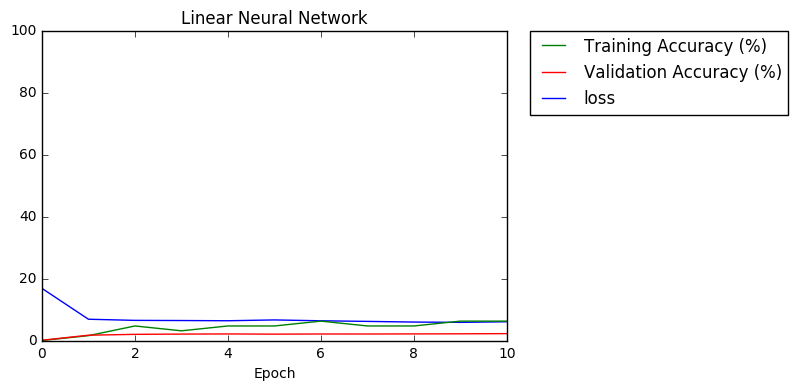

In [80]:
# Variables
epochs = 10
batch_size = 64
steps_num = int(len(train_y) / batch_size * epochs)
reg_constant = 5e-4
flat_data_size = img_size * img_size * channels_num
train_accuracies = []
valid_accuracies = []
losses = []

# Graph
graph = tf.Graph()
with graph.as_default():
    # Data
    train_X_flat = train_X.reshape((-1, flat_data_size))
    valid_X_flat = valid_X.reshape((-1, flat_data_size))
    test_X_flat = test_X.reshape((-1, flat_data_size))
    train_X_tf = tf.placeholder(tf.float32, (batch_size, flat_data_size))
    train_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))
    valid_X_tf = tf.constant(valid_X_flat)
    test_X_tf = tf.constant(test_X_flat)

    # Weights
    weights_1 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1))
    weights_2 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1))
    weights_3 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1))
    weights_4 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1))
    weights_5 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1))

    # Biases
    bias_1 = tf.Variable(tf.zeros(labels_num))
    bias_2 = tf.Variable(tf.zeros(labels_num))
    bias_3 = tf.Variable(tf.zeros(labels_num))
    bias_4 = tf.Variable(tf.zeros(labels_num))
    bias_5 = tf.Variable(tf.zeros(labels_num))

    # Model
    def model(data):
        output_1 = tf.matmul(data, weights_1) + bias_1
        output_2 = tf.matmul(data, weights_2) + bias_2
        output_3 = tf.matmul(data, weights_3) + bias_3
        output_4 = tf.matmul(data, weights_4) + bias_4
        output_5 = tf.matmul(data, weights_5) + bias_5
        return (output_1, output_2, output_3, output_4, output_5)

    # Output
    (train_output_1, 
     train_output_2, 
     train_output_3, 
     train_output_4, 
     train_output_5) = model(train_X_tf)
    
    (valid_output_1, 
     valid_output_2, 
     valid_output_3, 
     valid_output_4, 
     valid_output_5) = model(valid_X_tf)
    
    (test_output_1, 
     test_output_2, 
     test_output_3, 
     test_output_4, 
     test_output_5) = model(test_X_tf)
    
    # Loss
    regularization = reg_constant * (tf.nn.l2_loss(weights_1) + 
                                     tf.nn.l2_loss(weights_2) + 
                                     tf.nn.l2_loss(weights_3) + 
                                     tf.nn.l2_loss(weights_4) + 
                                     tf.nn.l2_loss(weights_5))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_output_1, train_y_tf[:,0,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_2, train_y_tf[:,1,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_3, train_y_tf[:,2,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_4, train_y_tf[:,3,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_5, train_y_tf[:,4,:]) + 
                          regularization)

    # Optimizer
    optimizer = tf.train.AdamOptimizer().minimize(loss)

    # Predictions
    train_preds = tf.pack((tf.nn.softmax(train_output_1), 
                          tf.nn.softmax(train_output_2), 
                          tf.nn.softmax(train_output_3), 
                          tf.nn.softmax(train_output_4), 
                          tf.nn.softmax(train_output_5)), 1)

    valid_preds = tf.pack((tf.nn.softmax(valid_output_1), 
                          tf.nn.softmax(valid_output_2), 
                          tf.nn.softmax(valid_output_3), 
                          tf.nn.softmax(valid_output_4), 
                          tf.nn.softmax(valid_output_5)), 1)

    test_preds = tf.pack((tf.nn.softmax(test_output_1), 
                         tf.nn.softmax(test_output_2), 
                         tf.nn.softmax(test_output_3), 
                         tf.nn.softmax(test_output_4), 
                         tf.nn.softmax(test_output_5)), 1)

# Session
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    
    for i in xrange(steps_num):
        # Get batch data and labels
        batch_start = batch_size * i % (train_y.shape[0] - batch_size)
        batch_end = batch_start + batch_size
        batch_X = train_X_flat[batch_start:batch_end,:]
        batch_y = train_y[batch_start:batch_end,:]
        feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y}
        _, l, preds = session.run([optimizer, loss, train_preds], feed_dict)
        
        # Report validation accuracy
        if i % int(steps_num / epochs) == 0:
            losses.append(l)
            train_accuracy = accuracy(preds, batch_y)
            train_accuracies.append(train_accuracy)
            valid_preds_eval = valid_preds.eval()            
            valid_accuracy = accuracy(valid_preds_eval, valid_y)            
            valid_accuracies.append(valid_accuracy)
            valid_f1 = f1(valid_preds_eval, valid_y)
                                    
            print('Epoch %d: Loss = %.2f, Training accuracy = %.2f%%, Validation accuracy = %.2f%%\n' 
                  % (int(i / int(steps_num / epochs)), l, train_accuracy, valid_accuracy))
    
    test_preds_eval = test_preds.eval()
    print('Test set accuracy = %.2f%%' % accuracy(test_preds_eval, test_y))
        
# Plot training graph to access performance
l, = plt.plot(losses)
ta, = plt.plot(train_accuracies)
va, = plt.plot(valid_accuracies)
plt.xlabel('Epoch')
plt.ylim(0, 100)
plt.xlim(0, 10)
plt.title('Linear Neural Network')
plt.legend([ta, va, l], ['Training Accuracy (%)', 'Validation Accuracy (%)', 'loss'], 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [81]:
# Compare predictions with labels
print('Labels:')
print(np.argmax(test_y[:10], 2))
print('\nPredictions:')
print(np.argmax(test_preds_eval[:10], 2))

Labels:
[[ 5 10 10 10 10]
 [ 2  1  0 10 10]
 [ 6 10 10 10 10]
 [ 1 10 10 10 10]
 [ 9 10 10 10 10]
 [ 1 10 10 10 10]
 [ 1  8  3 10 10]
 [ 6  5 10 10 10]
 [ 1  4  4 10 10]
 [ 1  6 10 10 10]]

Predictions:
[[ 1 10 10 10 10]
 [ 2  4 10 10 10]
 [ 4 10 10 10 10]
 [ 2 10 10 10 10]
 [ 1 10 10 10 10]
 [ 6 10 10 10 10]
 [ 2  1 10 10 10]
 [ 1 10 10 10 10]
 [ 1  1  4 10 10]
 [ 2  4 10 10 10]]


# Deep Neural Network

Epoch 0: Loss = 41.60, Training accuracy = 0.00%, Validation accuracy = 0.07%

Epoch 1: Loss = 5.63, Training accuracy = 1.56%, Validation accuracy = 3.40%

Epoch 2: Loss = 4.79, Training accuracy = 12.50%, Validation accuracy = 5.52%

Epoch 3: Loss = 4.34, Training accuracy = 10.94%, Validation accuracy = 10.14%

Epoch 4: Loss = 4.15, Training accuracy = 12.50%, Validation accuracy = 13.25%

Epoch 5: Loss = 4.14, Training accuracy = 10.94%, Validation accuracy = 14.29%

Epoch 6: Loss = 3.99, Training accuracy = 17.19%, Validation accuracy = 16.59%

Epoch 7: Loss = 3.94, Training accuracy = 20.31%, Validation accuracy = 18.14%

Epoch 8: Loss = 3.80, Training accuracy = 15.62%, Validation accuracy = 18.65%

Epoch 9: Loss = 3.65, Training accuracy = 18.75%, Validation accuracy = 19.48%

Epoch 10: Loss = 3.85, Training accuracy = 20.31%, Validation accuracy = 20.41%

Test set accuracy = 25.70%


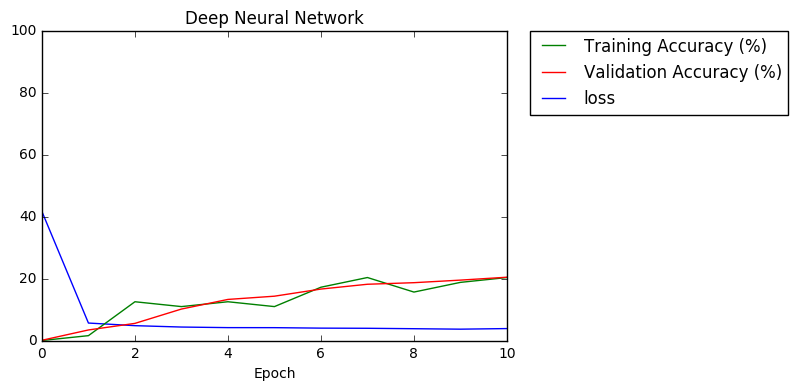

In [82]:
# Hyperparameters
epochs = 10
batch_size = 64
steps_num = int(len(train_y) / batch_size * epochs)
reg_constant = 5e-4
dropout_rate = 0.5
flat_data_size = img_size * img_size * channels_num
hidden_1_nodes = 1024
hidden_2_nodes = 128
train_accuracies = []
valid_accuracies = []
losses = []

# Graph
graph = tf.Graph()
with graph.as_default():
    # Data
    train_X_flat = train_X.reshape((-1, flat_data_size))
    valid_X_flat = valid_X.reshape((-1, flat_data_size))
    test_X_flat = test_X.reshape((-1, flat_data_size))
    train_X_tf = tf.placeholder(tf.float32, (batch_size, flat_data_size))
    train_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))
    valid_X_tf = tf.constant(valid_X_flat)
    test_X_tf = tf.constant(test_X_flat)

    # First hidden weights
    hidden_1_weights = tf.Variable(tf.random_normal((flat_data_size, hidden_1_nodes), stddev=0.1))

    # First hidden biases
    hidden_1_biases = tf.Variable(tf.zeros(hidden_1_nodes))
    
    # Second hidden weights
    hidden_2_weights = tf.Variable(tf.random_normal((hidden_1_nodes, hidden_2_nodes), stddev=0.1))

    # Second hidden biases
    hidden_2_biases = tf.Variable(tf.zeros(hidden_2_nodes))
    
    # Output weights
    output_1_weights = tf.Variable(tf.random_normal((hidden_2_nodes, labels_num), stddev=0.1))
    output_2_weights = tf.Variable(tf.random_normal((hidden_2_nodes, labels_num), stddev=0.1))
    output_3_weights = tf.Variable(tf.random_normal((hidden_2_nodes, labels_num), stddev=0.1))
    output_4_weights = tf.Variable(tf.random_normal((hidden_2_nodes, labels_num), stddev=0.1))
    output_5_weights = tf.Variable(tf.random_normal((hidden_2_nodes, labels_num), stddev=0.1))

    # Output biases
    output_1_biases = tf.Variable(tf.zeros(labels_num))
    output_2_biases = tf.Variable(tf.zeros(labels_num))
    output_3_biases = tf.Variable(tf.zeros(labels_num))
    output_4_biases = tf.Variable(tf.zeros(labels_num))
    output_5_biases = tf.Variable(tf.zeros(labels_num)) 

    # Model
    def model(data, dropout):
        # Compute first hidden layer
        hidden_1 = tf.nn.relu(tf.matmul(data, hidden_1_weights) + hidden_1_biases)
                            
        # Compute second hidden layer
        hidden_2 = tf.nn.relu(tf.matmul(hidden_1, hidden_2_weights) + hidden_2_biases)
        
        # Dropout regularization and output
        if dropout:
            hidden_2_dropout = tf.nn.dropout(hidden_2, dropout_rate)
            output_1 = tf.matmul(hidden_2_dropout, output_1_weights) + output_1_biases
            output_2 = tf.matmul(hidden_2_dropout, output_2_weights) + output_2_biases
            output_3 = tf.matmul(hidden_2_dropout, output_3_weights) + output_3_biases
            output_4 = tf.matmul(hidden_2_dropout, output_4_weights) + output_4_biases
            output_5 = tf.matmul(hidden_2_dropout, output_5_weights) + output_5_biases
        else:
            output_1 = tf.matmul(hidden_2, output_1_weights) + output_1_biases
            output_2 = tf.matmul(hidden_2, output_2_weights) + output_2_biases
            output_3 = tf.matmul(hidden_2, output_3_weights) + output_3_biases
            output_4 = tf.matmul(hidden_2, output_4_weights) + output_4_biases
            output_5 = tf.matmul(hidden_2, output_5_weights) + output_5_biases
    
        # Return outputs
        return (output_1, output_2, output_3, output_4, output_5)

    # Output
    (train_output_1, 
     train_output_2, 
     train_output_3, 
     train_output_4, 
     train_output_5) = model(train_X_tf, True)
    
    (valid_output_1, 
     valid_output_2, 
     valid_output_3, 
     valid_output_4, 
     valid_output_5) = model(valid_X_tf, False)
    
    (test_output_1, 
     test_output_2, 
     test_output_3, 
     test_output_4, 
     test_output_5) = model(test_X_tf, False)
    
    # L2 regularization
    regularization = reg_constant * (tf.nn.l2_loss(output_1_weights) + 
                                     tf.nn.l2_loss(output_2_weights) + 
                                     tf.nn.l2_loss(output_3_weights) + 
                                     tf.nn.l2_loss(output_4_weights) + 
                                     tf.nn.l2_loss(output_5_weights))
    
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_output_1, train_y_tf[:,0,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_2, train_y_tf[:,1,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_3, train_y_tf[:,2,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_4, train_y_tf[:,3,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_5, train_y_tf[:,4,:]) + 
                          regularization)

    # Optimizer
    optimizer = tf.train.AdamOptimizer().minimize(loss)

    # Predictions
    train_preds = tf.pack((tf.nn.softmax(train_output_1), 
                          tf.nn.softmax(train_output_2), 
                          tf.nn.softmax(train_output_3), 
                          tf.nn.softmax(train_output_4), 
                          tf.nn.softmax(train_output_5)), 1)

    valid_preds = tf.pack((tf.nn.softmax(valid_output_1), 
                          tf.nn.softmax(valid_output_2), 
                          tf.nn.softmax(valid_output_3), 
                          tf.nn.softmax(valid_output_4), 
                          tf.nn.softmax(valid_output_5)), 1)

    test_preds = tf.pack((tf.nn.softmax(test_output_1), 
                         tf.nn.softmax(test_output_2), 
                         tf.nn.softmax(test_output_3), 
                         tf.nn.softmax(test_output_4), 
                         tf.nn.softmax(test_output_5)), 1)

# Session
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    
    # Train
    for i in xrange(steps_num):
        batch_start = batch_size * i % (train_y.shape[0] - batch_size)
        batch_end = batch_start + batch_size
        batch_X = train_X_flat[batch_start:batch_end,:]
        batch_y = train_y[batch_start:batch_end,:]
        feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y}
        _, l, preds = session.run([optimizer, loss, train_preds], feed_dict)        
        
        # Report validation accuracy
        if i % int(steps_num / epochs) == 0:
            losses.append(l)
            train_accuracy = accuracy(preds, batch_y)
            train_accuracies.append(train_accuracy)
            valid_preds_eval = valid_preds.eval()            
            valid_accuracy = accuracy(valid_preds_eval, valid_y)            
            valid_accuracies.append(valid_accuracy)
            valid_f1 = f1(valid_preds_eval, valid_y)
                                    
            print('Epoch %d: Loss = %.2f, Training accuracy = %.2f%%, Validation accuracy = %.2f%%\n' 
                  % (int(i / int(steps_num / epochs)), l, train_accuracy, valid_accuracy))
    
    test_preds_eval = test_preds.eval()
    print('Test set accuracy = %.2f%%' % accuracy(test_preds_eval, test_y))
        
# Plot training graph to access performance
l, = plt.plot(losses)
ta, = plt.plot(train_accuracies)
va, = plt.plot(valid_accuracies)
plt.xlabel('Epoch')
plt.ylim(0, 100)
plt.xlim(0, 10)
plt.title('Deep Neural Network')
plt.legend([ta, va, l], ['Training Accuracy (%)', 'Validation Accuracy (%)', 'loss'], 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [83]:
# Compare predictions with labels
print('Labels:')
print(np.argmax(test_y[:10], 2))
print('\nPredictions:')
print(np.argmax(test_preds_eval[:10], 2))

Labels:
[[ 5 10 10 10 10]
 [ 2  1  0 10 10]
 [ 6 10 10 10 10]
 [ 1 10 10 10 10]
 [ 9 10 10 10 10]
 [ 1 10 10 10 10]
 [ 1  8  3 10 10]
 [ 6  5 10 10 10]
 [ 1  4  4 10 10]
 [ 1  6 10 10 10]]

Predictions:
[[ 1 10 10 10 10]
 [ 2  0 10 10 10]
 [ 1 10 10 10 10]
 [ 9 10 10 10 10]
 [ 9 10 10 10 10]
 [ 1 10 10 10 10]
 [ 1  0  5 10 10]
 [ 5 10 10 10 10]
 [ 1  4  0 10 10]
 [ 1  0 10 10 10]]


# Convolutional Neural Network

In [88]:
# Helper functions
def create_weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def create_bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

def create_conv_layer(data, weights):
    return tf.nn.conv2d(data, weights, [1, conv_stride, conv_stride, 1], padding)

def create_pool_layer(data):
    return tf.nn.max_pool(data, pool_window_size, pool_stride, padding)

def get_conv_shape(data_shape, weights_shape):
    if padding == 'VALID':
        new_height = int(np.ceil((data_shape[1] - weights_shape[0] + 1) / conv_stride))
        new_width = int(np.ceil((data_shape[2] - weights_shape[1] + 1) / conv_stride))
    else:
        new_height = int(np.ceil(data_shape[1] / conv_stride))
        new_width = int(np.ceil(data_shape[2] / conv_stride))
    return (data_shape[0], new_height, new_width, weights_shape[3])

def get_pool_shape(data_shape):
    new_height = int(np.ceil(data_shape[1] / pool_stride[1]))
    new_width = int(np.ceil(data_shape[2] / pool_stride[2]))
    return (data_shape[0], new_height, new_width, data_shape[3])

In [89]:
# Perform cross validation
best = (0, 0)
for reg in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]:
    # Hyperparameters
    epochs = 1
    batch_size = 64
    steps_num = int(len(train_y) / batch_size * epochs)
    patch_size = 5
    conv_depth_1 = 16
    conv_depth_2 = 32
    conv_depth_3 = 64
    conv_depth_4 = 128
    full_nodes = 128
    dropout_rate = 0.5
    conv_stride = 1
    pool_window_size = [1, 2, 2, 1]
    pool_stride = [1, 2, 2, 1]
    padding = 'SAME'

    # Graph
    graph = tf.Graph()
    with graph.as_default():
        # Data
        train_X_tf = tf.placeholder(tf.float32, (batch_size, img_size, img_size, channels_num))
        train_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))
        valid_X_tf = tf.placeholder(tf.float32, (batch_size, img_size, img_size, channels_num))
        valid_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))
        test_X_tf = tf.placeholder(tf.float32, (batch_size, img_size, img_size, channels_num))
        test_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))

        # First convolution layer
        conv_1_weights = create_weight((patch_size, patch_size, channels_num, conv_depth_1))
        conv_1_biases = create_bias((conv_depth_1,))
        conv_1_shape = get_conv_shape(train_X_tf.get_shape().as_list(), 
                                      conv_1_weights.get_shape().as_list())

        # Second convolution layer 
        conv_2_weights = create_weight((patch_size, patch_size, conv_depth_1, conv_depth_1))
        conv_2_biases = create_bias((conv_depth_1,))
        pool_1_shape = get_pool_shape(conv_1_shape)

        # Third convolution layer 
        conv_3_weights = create_weight((patch_size, patch_size, conv_depth_1, conv_depth_2))
        conv_3_biases = create_bias((conv_depth_2,))
        conv_2_shape = get_conv_shape(pool_1_shape, conv_3_weights.get_shape().as_list())

        # Fourth convolution layer 
        conv_4_weights = create_weight((patch_size, patch_size, conv_depth_2, conv_depth_2))
        conv_4_biases = create_bias((conv_depth_2,))
        pool_2_shape = get_pool_shape(conv_2_shape)

        # Fifth convolution layer 
        conv_5_weights = create_weight((patch_size, patch_size, conv_depth_2, conv_depth_3))
        conv_5_biases = create_bias((conv_depth_3,))
        conv_3_shape = get_conv_shape(pool_2_shape, conv_5_weights.get_shape().as_list())

        # Sixth convolution layer 
        conv_6_weights = create_weight((patch_size, patch_size, conv_depth_3, conv_depth_3))
        conv_6_biases = create_bias((conv_depth_3,))
        pool_3_shape = get_pool_shape(conv_3_shape)

        # Seventh convolution layer 
        conv_7_weights = create_weight((patch_size, patch_size, conv_depth_3, conv_depth_4))
        conv_7_biases = create_bias((conv_depth_4,))
        conv_4_shape = get_conv_shape(pool_3_shape, conv_7_weights.get_shape().as_list())

        # Eighth convolution layer 
        conv_8_weights = create_weight((patch_size, patch_size, conv_depth_4, conv_depth_4))
        conv_8_biases = create_bias((conv_depth_4,))
        pool_4_shape = get_pool_shape(conv_4_shape)

        # Fully connected layer
        final_pooled_flat = pool_4_shape[1] * pool_4_shape[2] * pool_4_shape[3]
        weights_full = create_weight((final_pooled_flat, full_nodes))
        biases_full = create_bias((full_nodes,))

        # Output layer
        output_1_weights = create_weight((full_nodes, labels_num))
        output_2_weights = create_weight((full_nodes, labels_num))
        output_3_weights = create_weight((full_nodes, labels_num))
        output_4_weights = create_weight((full_nodes, labels_num))
        output_5_weights = create_weight((full_nodes, labels_num))
        output_1_biases = create_bias((labels_num,))
        output_2_biases = create_bias((labels_num,))
        output_3_biases = create_bias((labels_num,))
        output_4_biases = create_bias((labels_num,))
        output_5_biases = create_bias((labels_num,)) 

        # Model
        def model(data, dropout):
            # First convolution layer
            conv_1 = tf.nn.relu(create_conv_layer(data, conv_1_weights) + conv_1_biases)

            # Second convolution layer
            conv_2 = tf.nn.relu(create_conv_layer(conv_1, conv_2_weights) + conv_2_biases)

            # First pooling layer
            pool_1 = create_pool_layer(conv_2)

            # Third convolution layer
            conv_3 = tf.nn.relu(create_conv_layer(pool_1, conv_3_weights) + conv_3_biases)

            # Fourth convolution layer
            conv_4 = tf.nn.relu(create_conv_layer(conv_3, conv_4_weights) + conv_4_biases)

            # Second pooling layer
            pool_2 = create_pool_layer(conv_4)

            # Fifth convolution layer
            conv_5 = tf.nn.relu(create_conv_layer(pool_2, conv_5_weights) + conv_5_biases)

            # Sixth convolution layer
            conv_6 = tf.nn.relu(create_conv_layer(conv_5, conv_6_weights) + conv_6_biases)

            # Third pooling layer
            pool_3 = create_pool_layer(conv_6)

            # Seventh convolutional layer
            conv_7 = tf.nn.relu(create_conv_layer(pool_3, conv_7_weights) + conv_7_biases)

            # Eighth convolutional layer
            conv_8 = tf.nn.relu(create_conv_layer(conv_7, conv_8_weights) + conv_8_biases)

            # Fourth pooling layer
            pool_4 = create_pool_layer(conv_8)

            # Reshape data
            data_size = pool_4.get_shape().as_list()[0]
            reshaped = tf.reshape(pool_4, (data_size, final_pooled_flat))

            # First fully connected layer
            full = tf.nn.relu(tf.matmul(reshaped, weights_full) + biases_full)

            # Dropout regularization and output layer
            if dropout:
                full_dropped = tf.nn.dropout(full, dropout_rate)
                output_1 = tf.matmul(full_dropped, output_1_weights) + output_1_biases
                output_2 = tf.matmul(full_dropped, output_2_weights) + output_2_biases
                output_3 = tf.matmul(full_dropped, output_3_weights) + output_3_biases
                output_4 = tf.matmul(full_dropped, output_4_weights) + output_4_biases
                output_5 = tf.matmul(full_dropped, output_5_weights) + output_5_biases
            else:
                output_1 = tf.matmul(full, output_1_weights) + output_1_biases
                output_2 = tf.matmul(full, output_2_weights) + output_2_biases
                output_3 = tf.matmul(full, output_3_weights) + output_3_biases
                output_4 = tf.matmul(full, output_4_weights) + output_4_biases
                output_5 = tf.matmul(full, output_5_weights) + output_5_biases

            # Return outputs
            return (output_1, output_2, output_3, output_4, output_5)

        # Output
        (train_output_1, 
         train_output_2, 
         train_output_3, 
         train_output_4, 
         train_output_5) = model(train_X_tf, True)
        
        (valid_output_1, 
         valid_output_2, 
         valid_output_3, 
         valid_output_4, 
         valid_output_5) = model(valid_X_tf, False)
        
        (test_output_1, 
         test_output_2, 
         test_output_3, 
         test_output_4, 
         test_output_5) = model(test_X_tf, False)

        # L2 regularization on output layer
        regularization = reg * (tf.nn.l2_loss(output_1_weights) + 
                                         tf.nn.l2_loss(output_2_weights) + 
                                         tf.nn.l2_loss(output_3_weights) + 
                                         tf.nn.l2_loss(output_4_weights) + 
                                         tf.nn.l2_loss(output_5_weights) + 
                                         tf.nn.l2_loss(output_1_biases) + 
                                         tf.nn.l2_loss(output_2_biases) + 
                                         tf.nn.l2_loss(output_3_biases) + 
                                         tf.nn.l2_loss(output_4_biases) + 
                                         tf.nn.l2_loss(output_5_biases))
        # Loss
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_output_1, train_y_tf[:,0,:]) +
                              tf.nn.softmax_cross_entropy_with_logits(train_output_2, train_y_tf[:,1,:]) +
                              tf.nn.softmax_cross_entropy_with_logits(train_output_3, train_y_tf[:,2,:]) +
                              tf.nn.softmax_cross_entropy_with_logits(train_output_4, train_y_tf[:,3,:]) +
                              tf.nn.softmax_cross_entropy_with_logits(train_output_5, train_y_tf[:,4,:]) +
                              regularization)

        # Optimizer
        optimizer = tf.train.AdamOptimizer().minimize(loss)

        # Predictions
        train_preds = tf.pack((tf.nn.softmax(train_output_1), 
                              tf.nn.softmax(train_output_2), 
                              tf.nn.softmax(train_output_3), 
                              tf.nn.softmax(train_output_4), 
                              tf.nn.softmax(train_output_5)), 1)

        valid_preds = tf.pack((tf.nn.softmax(valid_output_1), 
                              tf.nn.softmax(valid_output_2), 
                              tf.nn.softmax(valid_output_3), 
                              tf.nn.softmax(valid_output_4), 
                              tf.nn.softmax(valid_output_5)), 1)

        test_preds = tf.pack((tf.nn.softmax(test_output_1), 
                             tf.nn.softmax(test_output_2), 
                             tf.nn.softmax(test_output_3), 
                             tf.nn.softmax(test_output_4), 
                             tf.nn.softmax(test_output_5)), 1)

    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()

        for i in xrange(steps_num):
            # Get batch data and labels
            batch_start = batch_size * i % (train_y.shape[0] - batch_size)
            batch_end = batch_start + batch_size
            batch_X = train_X[batch_start:batch_end,:]
            batch_y = train_y[batch_start:batch_end,:]
            feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y}
            _, l, preds = session.run([optimizer, loss, train_preds], feed_dict)       

        test_preds_total = np.ndarray(test_y.shape)
        for j in xrange(int(np.floor(test_y.shape[0] / batch_size))):
            batch_start_test = batch_size * j
            batch_end_test = batch_start_test + batch_size
            batch_X_test = test_X[batch_start_test:batch_end_test,:,:,:]
            batch_y_test = test_y[batch_start_test:batch_end_test,:,:]                
            feed_dict = {test_X_tf: batch_X_test, test_y_tf: batch_y_test}
            test_preds_total[batch_start_test:batch_end_test,:,:] = session.run(test_preds, feed_dict) 

        test_preds_eval = test_preds_total
        f1_score = f1(test_preds_eval, test_y)
        if f1_score > best[0]:
            best = (f1_score, reg)
        print('F1 = %.2f, lambda = %.5f' % (f1_score, reg))

print('\nBest: F1 = %.2f, lambda = %.5f' % (best[0], best[1]))

F1 = 0.89, lambda = 0.00001
F1 = 0.81, lambda = 0.00010
F1 = 0.90, lambda = 0.00100
F1 = 0.91, lambda = 0.01000
F1 = 0.89, lambda = 0.10000
F1 = 0.90, lambda = 1.00000

Best: F1 = 0.91, lambda = 0.01000


Epoch 0: Loss = 1497.57, Training accuracy = 0.00%, Validation accuracy = 0.30%

Epoch 1: Loss = 2.97, Training accuracy = 32.81%, Validation accuracy = 40.90%

Epoch 2: Loss = 1.25, Training accuracy = 73.44%, Validation accuracy = 79.92%

Epoch 3: Loss = 0.99, Training accuracy = 78.12%, Validation accuracy = 85.55%

Epoch 4: Loss = 0.86, Training accuracy = 87.50%, Validation accuracy = 87.00%

Epoch 5: Loss = 0.98, Training accuracy = 85.94%, Validation accuracy = 88.28%

Epoch 6: Loss = 0.80, Training accuracy = 85.94%, Validation accuracy = 89.39%

Epoch 7: Loss = 0.54, Training accuracy = 87.50%, Validation accuracy = 89.20%

Epoch 8: Loss = 0.63, Training accuracy = 85.94%, Validation accuracy = 89.15%

Epoch 9: Loss = 0.63, Training accuracy = 82.81%, Validation accuracy = 89.36%

Epoch 10: Loss = 0.85, Training accuracy = 81.25%, Validation accuracy = 88.62%

Test set accuracy = 87.38%


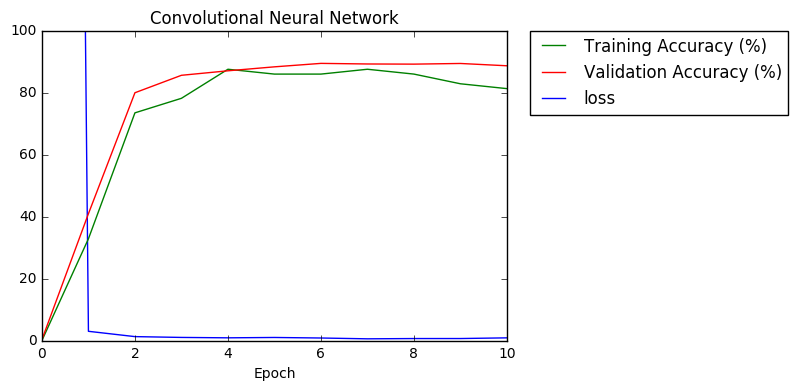

In [90]:
# Hyperparameters
epochs = 10
batch_size = 64
steps_num = int(len(train_y) / batch_size * epochs)
patch_size = 5
conv_depth_1 = 16
conv_depth_2 = 32
conv_depth_3 = 64
conv_depth_4 = 128
full_nodes = 128
reg_constant = best[1]
dropout_rate = 0.5
conv_stride = 1
pool_window_size = [1, 2, 2, 1]
pool_stride = [1, 2, 2, 1]
padding = 'SAME'
train_accuracies = []
valid_accuracies = []
losses = []

graph = tf.Graph()
with graph.as_default():

    # Data (don't flatten as we did before)
    train_X_tf = tf.placeholder(tf.float32, (batch_size, img_size, img_size, channels_num))
    train_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))
    valid_X_tf = tf.placeholder(tf.float32, (batch_size, img_size, img_size, channels_num))
    valid_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))
    test_X_tf = tf.placeholder(tf.float32, (batch_size, img_size, img_size, channels_num))
    test_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))

    # First convolution layer
    conv_1_weights = create_weight((patch_size, patch_size, channels_num, conv_depth_1))
    conv_1_biases = create_bias((conv_depth_1,))
    conv_1_shape = get_conv_shape(train_X_tf.get_shape().as_list(), 
                                  conv_1_weights.get_shape().as_list())

    # Second convolution layer 
    conv_2_weights = create_weight((patch_size, patch_size, conv_depth_1, conv_depth_1))
    conv_2_biases = create_bias((conv_depth_1,))
    pool_1_shape = get_pool_shape(conv_1_shape)

    # Third convolution layer 
    conv_3_weights = create_weight((patch_size, patch_size, conv_depth_1, conv_depth_2))
    conv_3_biases = create_bias((conv_depth_2,))
    conv_2_shape = get_conv_shape(pool_1_shape, conv_3_weights.get_shape().as_list())

    # Fourth convolution layer 
    conv_4_weights = create_weight((patch_size, patch_size, conv_depth_2, conv_depth_2))
    conv_4_biases = create_bias((conv_depth_2,))
    pool_2_shape = get_pool_shape(conv_2_shape)

    # Fifth convolution layer 
    conv_5_weights = create_weight((patch_size, patch_size, conv_depth_2, conv_depth_3))
    conv_5_biases = create_bias((conv_depth_3,))
    conv_3_shape = get_conv_shape(pool_2_shape, conv_5_weights.get_shape().as_list())

    # Sixth convolution layer 
    conv_6_weights = create_weight((patch_size, patch_size, conv_depth_3, conv_depth_3))
    conv_6_biases = create_bias((conv_depth_3,))
    pool_3_shape = get_pool_shape(conv_3_shape)

    # Seventh convolution layer 
    conv_7_weights = create_weight((patch_size, patch_size, conv_depth_3, conv_depth_4))
    conv_7_biases = create_bias((conv_depth_4,))
    conv_4_shape = get_conv_shape(pool_3_shape, conv_7_weights.get_shape().as_list())

    # Eighth convolution layer 
    conv_8_weights = create_weight((patch_size, patch_size, conv_depth_4, conv_depth_4))
    conv_8_biases = create_bias((conv_depth_4,))
    pool_4_shape = get_pool_shape(conv_4_shape)

    # Fully connected layer
    final_pooled_flat = pool_4_shape[1] * pool_4_shape[2] * pool_4_shape[3]
    weights_full = create_weight((final_pooled_flat, full_nodes))
    biases_full = create_bias((full_nodes,))

    # Output layer
    output_1_weights = create_weight((full_nodes, labels_num))
    output_2_weights = create_weight((full_nodes, labels_num))
    output_3_weights = create_weight((full_nodes, labels_num))
    output_4_weights = create_weight((full_nodes, labels_num))
    output_5_weights = create_weight((full_nodes, labels_num))
    output_1_biases = create_bias((labels_num,))
    output_2_biases = create_bias((labels_num,))
    output_3_biases = create_bias((labels_num,))
    output_4_biases = create_bias((labels_num,))
    output_5_biases = create_bias((labels_num,)) 

    # Model
    def model(data, dropout):
        # First convolution layer
        conv_1 = tf.nn.relu(create_conv_layer(data, conv_1_weights) + conv_1_biases)
        
        # Second convolution layer
        conv_2 = tf.nn.relu(create_conv_layer(conv_1, conv_2_weights) + conv_2_biases)
        
        # First pooling layer
        pool_1 = create_pool_layer(conv_2)

        # Third convolution layer
        conv_3 = tf.nn.relu(create_conv_layer(pool_1, conv_3_weights) + conv_3_biases)
        
        # Fourth convolution layer
        conv_4 = tf.nn.relu(create_conv_layer(conv_3, conv_4_weights) + conv_4_biases)
        
        # Second pooling layer
        pool_2 = create_pool_layer(conv_4)

        # Fifth convolution layer
        conv_5 = tf.nn.relu(create_conv_layer(pool_2, conv_5_weights) + conv_5_biases)
        
        # Sixth convolution layer
        conv_6 = tf.nn.relu(create_conv_layer(conv_5, conv_6_weights) + conv_6_biases)
        
        # Third pooling layer
        pool_3 = create_pool_layer(conv_6)
        
        # Seventh convolutional layer
        conv_7 = tf.nn.relu(create_conv_layer(pool_3, conv_7_weights) + conv_7_biases)
        
        # Eighth convolutional layer
        conv_8 = tf.nn.relu(create_conv_layer(conv_7, conv_8_weights) + conv_8_biases)
        
        # Fourth pooling layer
        pool_4 = create_pool_layer(conv_8)

        # Reshape data
        data_size = pool_4.get_shape().as_list()[0]
        reshaped = tf.reshape(pool_4, (data_size, final_pooled_flat))

        # First fully connected layer
        full = tf.nn.relu(tf.matmul(reshaped, weights_full) + biases_full)

        # Dropout regularization and output layer
        if dropout:
            full_dropped = tf.nn.dropout(full, dropout_rate)
            output_1 = tf.matmul(full_dropped, output_1_weights) + output_1_biases
            output_2 = tf.matmul(full_dropped, output_2_weights) + output_2_biases
            output_3 = tf.matmul(full_dropped, output_3_weights) + output_3_biases
            output_4 = tf.matmul(full_dropped, output_4_weights) + output_4_biases
            output_5 = tf.matmul(full_dropped, output_5_weights) + output_5_biases
        else:
            output_1 = tf.matmul(full, output_1_weights) + output_1_biases
            output_2 = tf.matmul(full, output_2_weights) + output_2_biases
            output_3 = tf.matmul(full, output_3_weights) + output_3_biases
            output_4 = tf.matmul(full, output_4_weights) + output_4_biases
            output_5 = tf.matmul(full, output_5_weights) + output_5_biases

        # Return outputs
        return (output_1, output_2, output_3, output_4, output_5)

    # Output
    (train_output_1, 
     train_output_2, 
     train_output_3, 
     train_output_4, 
     train_output_5) = model(train_X_tf, True)
    
    (valid_output_1, 
     valid_output_2, 
     valid_output_3, 
     valid_output_4, 
     valid_output_5) = model(valid_X_tf, False)
    
    (test_output_1, 
     test_output_2, 
     test_output_3, 
     test_output_4, 
     test_output_5) = model(test_X_tf, False)

    # L2 regularization on output layer
    regularization = reg_constant * (tf.nn.l2_loss(output_1_weights) + 
                                     tf.nn.l2_loss(output_2_weights) + 
                                     tf.nn.l2_loss(output_3_weights) + 
                                     tf.nn.l2_loss(output_4_weights) + 
                                     tf.nn.l2_loss(output_5_weights) + 
                                     tf.nn.l2_loss(output_1_biases) + 
                                     tf.nn.l2_loss(output_2_biases) + 
                                     tf.nn.l2_loss(output_3_biases) + 
                                     tf.nn.l2_loss(output_4_biases) + 
                                     tf.nn.l2_loss(output_5_biases))
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_output_1, train_y_tf[:,0,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_2, train_y_tf[:,1,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_3, train_y_tf[:,2,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_4, train_y_tf[:,3,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_output_5, train_y_tf[:,4,:]) + 
                          regularization)

    # Optimizer
    optimizer = tf.train.AdamOptimizer().minimize(loss)

    # Predictions
    train_preds = tf.pack((tf.nn.softmax(train_output_1), 
                          tf.nn.softmax(train_output_2), 
                          tf.nn.softmax(train_output_3), 
                          tf.nn.softmax(train_output_4), 
                          tf.nn.softmax(train_output_5)), 1)

    valid_preds = tf.pack((tf.nn.softmax(valid_output_1), 
                          tf.nn.softmax(valid_output_2), 
                          tf.nn.softmax(valid_output_3), 
                          tf.nn.softmax(valid_output_4), 
                          tf.nn.softmax(valid_output_5)), 1)

    test_preds = tf.pack((tf.nn.softmax(test_output_1), 
                         tf.nn.softmax(test_output_2), 
                         tf.nn.softmax(test_output_3), 
                         tf.nn.softmax(test_output_4), 
                         tf.nn.softmax(test_output_5)), 1)
    
# Session
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()

    # Train
    for i in xrange(steps_num):
        batch_start = batch_size * i % (train_y.shape[0] - batch_size)
        batch_end = batch_start + batch_size
        batch_X = train_X[batch_start:batch_end,:,:,:]
        batch_y = train_y[batch_start:batch_end,:,:]
        feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y}
        _, l, preds = session.run([optimizer, loss, train_preds], feed_dict)        

        # Report validation accuracy
        if i % int(steps_num / epochs) == 0:
            losses.append(l)
            train_accuracy = accuracy(preds, batch_y)
            train_accuracies.append(train_accuracy)

            valid_preds_total = np.ndarray(valid_y.shape)
            for j in xrange(int(np.floor(valid_y.shape[0] / batch_size))):
                batch_start_valid = batch_size * j
                batch_end_valid = batch_start_valid + batch_size
                batch_X_valid = valid_X[batch_start_valid:batch_end_valid,:,:,:]
                batch_y_valid = valid_y[batch_start_valid:batch_end_valid,:,:]                
                feed_dict = {valid_X_tf: batch_X_valid, valid_y_tf: batch_y_valid}
                valid_preds_total[batch_start_valid:batch_end_valid,:,:] = session.run(valid_preds, 
                                                                                       feed_dict) 

            valid_accuracy = accuracy(valid_preds_total, valid_y)
            valid_accuracies.append(valid_accuracy)            

            print('Epoch %d: Loss = %.2f, Training accuracy = %.2f%%, Validation accuracy = %.2f%%\n' 
                  % (int(i / int(steps_num / epochs)), l, train_accuracy, valid_accuracy))

    test_preds_total = np.ndarray(test_y.shape)
    for j in xrange(int(np.floor(test_y.shape[0] / batch_size))):
        batch_start_test = batch_size * j
        batch_end_test = batch_start_test + batch_size
        batch_X_test = test_X[batch_start_test:batch_end_test,:,:,:]
        batch_y_test = test_y[batch_start_test:batch_end_test,:,:]                
        feed_dict = {test_X_tf: batch_X_test, test_y_tf: batch_y_test}
        test_preds_total[batch_start_test:batch_end_test,:,:] = session.run(test_preds, feed_dict) 

    print('Test set accuracy = %.2f%%' % accuracy(test_preds_total, test_y))

# Plot training graph to access performance
l, = plt.plot(losses)
ta, = plt.plot(train_accuracies)
va, = plt.plot(valid_accuracies)
plt.xlabel('Epoch')
plt.ylim(0, 100)
plt.xlim(0, 10)
plt.title('Convolutional Neural Network')
plt.legend([ta, va, l], ['Training Accuracy (%)', 'Validation Accuracy (%)', 'loss'], 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [91]:
# Compare predictions with labels
print('Labels:')
print(np.argmax(test_y[:10], 2))
print('\nPredictions:')
print(np.argmax(test_preds_total[:10], 2))

Labels:
[[ 5 10 10 10 10]
 [ 2  1  0 10 10]
 [ 6 10 10 10 10]
 [ 1 10 10 10 10]
 [ 9 10 10 10 10]
 [ 1 10 10 10 10]
 [ 1  8  3 10 10]
 [ 6  5 10 10 10]
 [ 1  4  4 10 10]
 [ 1  6 10 10 10]]

Predictions:
[[ 5 10 10 10 10]
 [ 2  1  0 10 10]
 [ 6 10 10 10 10]
 [ 3 10 10 10 10]
 [ 9 10 10 10 10]
 [ 1 10 10 10 10]
 [ 1  8  3 10 10]
 [ 6  5 10 10 10]
 [ 1  4  4 10 10]
 [ 1  6 10 10 10]]
